# Ejercicios resueltos del libro *Programming Massively Parallel Processors: A Hands-on Approach*, capítulo 4: *Memory and data locality*

## Ejercicio 1: Suma de matrices (memoria compartida)

### Código de suma de matrices (laboratorio anterior, autoría propia):

In [ ]:
%%writefile ej31.cu

#include <iostream>

__global__
void mat_addition(float* C, float* A, float* B, int n){
  int i = blockIdx.y * blockDim.y + threadIdx.y;
  int j = blockIdx.x * blockDim.x + threadIdx.x;

  if (i >= n || j >= n) return;

  C[i * n + j] = A[i * n + j] + B[i * n + j];
}

int main(){
  int n = 128;

  float *host_A, *host_B, *host_C;
  float *dev_A, *dev_B, *dev_C;

  // allocating memory for the input and output matrices
  host_A = (float*)malloc(n * n * sizeof(float));
  host_B = (float*)malloc(n * n * sizeof(float));
  host_C = (float*)malloc(n * n * sizeof(float));

  for(int i = 0; i < n * n; i++){
    host_A[i] = rand() % 100;
    host_B[i] = rand() % 100;
  }

  cudaMalloc(&dev_A, n * n * sizeof(float));
  cudaMalloc(&dev_B, n * n * sizeof(float));
  cudaMalloc(&dev_C, n * n * sizeof(float));

  // transferring input data to device
  cudaMemcpy(dev_A, host_A, n * n * sizeof(float), cudaMemcpyHostToDevice);
  cudaMemcpy(dev_B, host_B, n * n * sizeof(float), cudaMemcpyHostToDevice);

  dim3 block(32, 16);
  dim3 grid((n + block.x - 1)/block.x,
            (n + block.y - 1)/block.y);

  //--------launch the kernel--------
  cudaEvent_t start, stop;
  cudaEventCreate(&start);
  cudaEventCreate(&stop);

  cudaEventRecord(start);

  mat_addition<<<grid, block>>>(dev_C, dev_A, dev_B, n);

  cudaDeviceSynchronize();

  cudaEventRecord(stop);
  cudaEventSynchronize(stop);

  float ms = 0.0f;
  cudaEventElapsedTime(&ms, start, stop);

  std::cout << "Tiempo GPU: " << ms << " ms\n";

  cudaEventDestroy(start);
  cudaEventDestroy(stop);
  //---------------------------------

  // transferring the output data to host
  cudaMemcpy(host_C, dev_C, n * n * sizeof(float), cudaMemcpyDeviceToHost);

  // test
  for(int i = 0; i < n; ++i){
    for(int j = 0; j < n; ++j)
      std::cout << host_C[i * n + j] << " ";
    std::cout << std::endl;
  }

  // freeing the device memory for the input and output data
  cudaFree(dev_A);
  cudaFree(dev_B);
  cudaFree(dev_C);

  free(host_A);
  free(host_B);
  free(host_C);

  return 0;
}


Writing ej31.cu


In [ ]:
%%shell

nvcc -arch=compute_75 -code=sm_75 ej31.cu -o ej31
./ej31

Tiempo GPU: 0.11472 ms
169 92 128 178 70 89 149 89 66 108 79 96 112 85 102 31 80 136 149 53 102 40 121 122 85 39 171 129 132 177 30 111 41 75 70 119 127 81 98 93 95 154 172 54 153 92 144 51 112 133 165 112 68 99 109 108 81 127 154 63 69 48 168 156 36 123 150 151 89 43 99 61 22 138 23 89 119 63 97 76 167 92 91 93 98 38 143 134 92 95 83 65 82 95 153 66 128 46 54 57 80 106 51 46 22 116 86 113 67 153 189 97 134 44 140 151 106 104 59 59 50 142 114 62 21 6 91 83 
56 70 87 24 140 61 86 36 151 129 139 104 111 127 123 180 195 132 81 185 92 124 174 118 43 101 97 99 120 68 46 129 7 85 76 118 25 50 107 33 77 142 44 91 177 114 164 122 110 121 82 111 188 114 90 55 87 98 148 149 105 102 163 98 88 17 115 85 46 8 105 110 117 80 156 44 101 36 81 144 113 97 46 185 139 36 160 145 111 148 163 86 96 35 64 55 98 58 191 142 41 31 81 85 110 69 131 42 33 113 114 78 77 109 138 155 187 87 119 122 110 58 103 77 84 90 115 163 
111 116 81 82 63 98 46 120 68 107 136 117 131 124 84 98 69 102 91 79 163 96 53 175 104 15

*Respuesta:*

Para el caso del código de adición de matrices, cada thread llama a una sección de memoria distinta cuando es necesario, tanto para las filas como para las columnas. Como no hay elementos que sean llamados repetidas veces, no hay una reducción en el consumo del ancho de banda de la memoria global por usar memoria compartida, pues se llamarán a todos las filas y columnas igualmente.

## Ejercicio 2:
Dibuja el equivalente de la figura 4.14 para una matriz $8\times 8$ con tiling de $2\times 2$ y $4\times 4$. Verifica que la reducción en el ancho de banda de la memoria global es, en efecto, proporcional a las dimensiones de los tiles.

Figura 4.14:

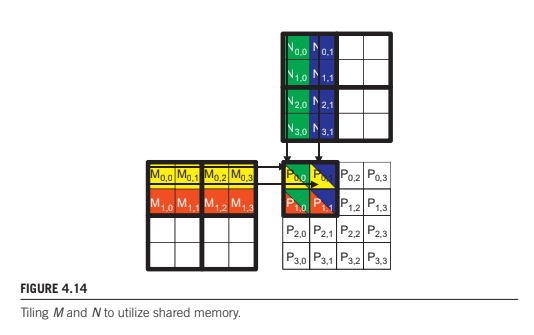

*Respuesta:*

$2\times 2$:

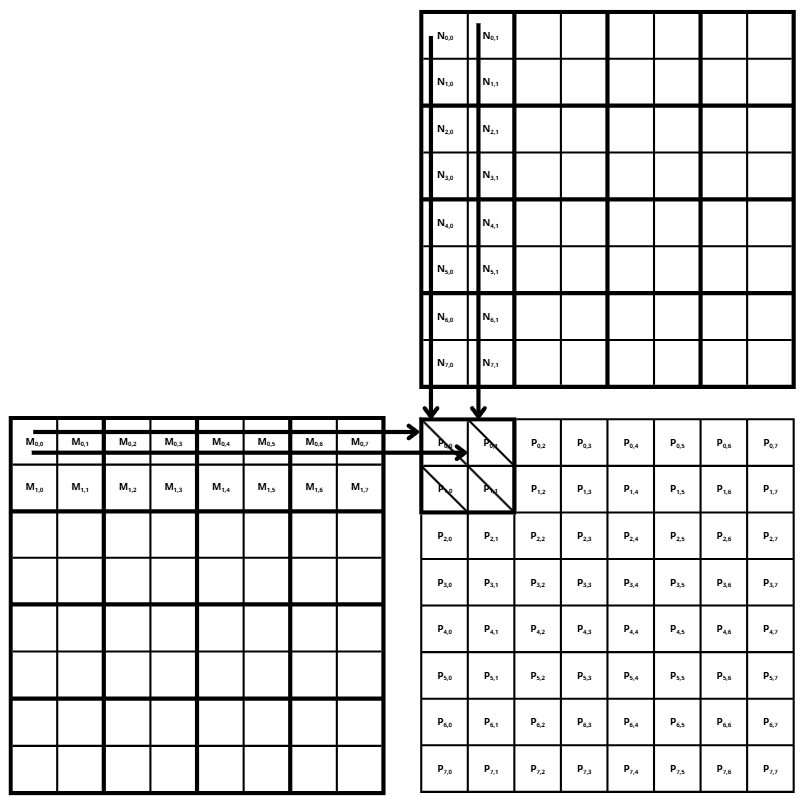

$4\times 4$:

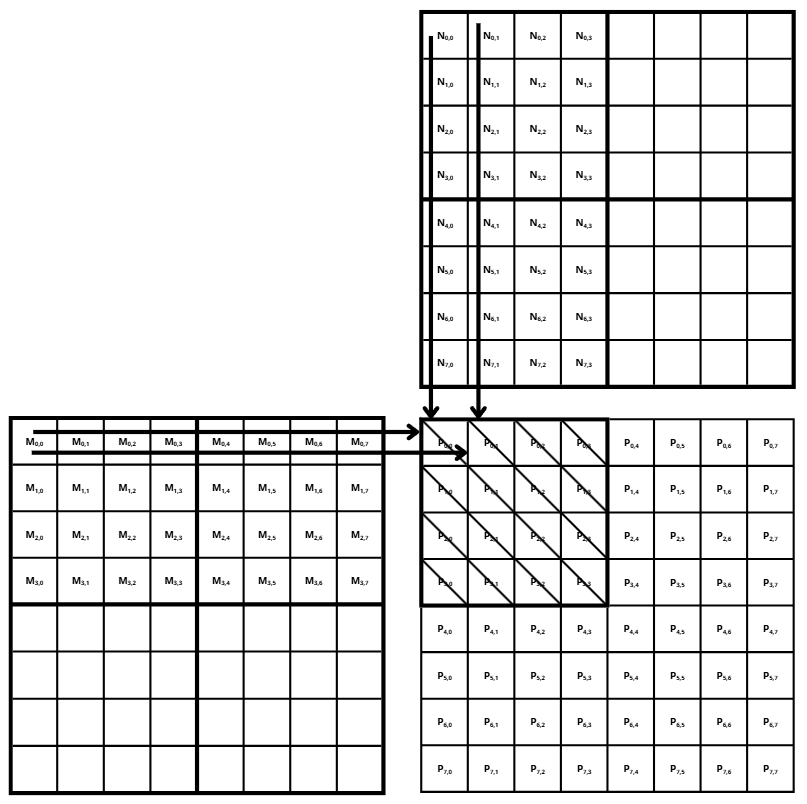

En el caso del tiling $2\times 2$, cada columna/fila se usa 2 veces, mientras que en el caso de $4\times 4$, cada columna/fila se usa 4 veces; de modo que la reducción en el ancho de banda de la memoria global es proporcional al tamaño de los tiles.

## Ejercicio 3:
¿Qué tipo de comportamiento erróneo en la ejecución puede suceder si uno o dos ```__syncthreads()``` se omiten en el kernel de la figura 4.16?

Figura 4.16:

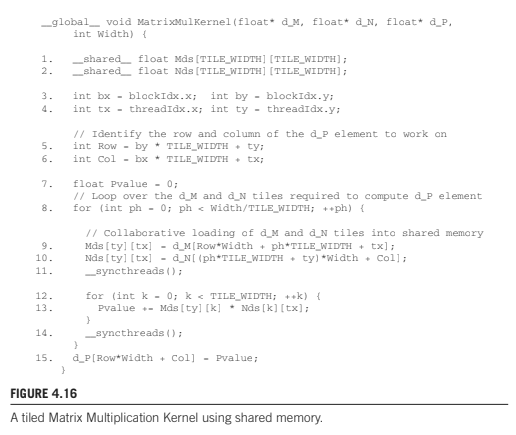


*Respuesta:*

En el caso del primer ```__syncthreads()```, omitirlo llevará a que los threads intenten actualizar la información de la memoria compartida sin esperar a que los demás threads confirmen su carga, lo que eventualmente llevará a errores.

En el caso del segundo ```__syncthreads()```, omitirlo llevará a los threads en el kernel a continuar trabajando sin confirmar la actualización de la memoria compartida, es decir, los demás podrían trabajar con datos desactualizados; lo que eventualmente llevará a errores.

## Ejercicio 4:
Asumiendo que la capacidad no es un problema para los registros o la memoria compartida, da una razón importante por la cual sería valioso usar memoria compartida en lugar de registros para almacenar valores traídos de la memoria global. Justifica tu respuesta.

*Respuesta:*

Las variables almacenadas en los registros son privados para cada thread. Esto significa que, para $N$ threads, se cargarán $N$ variables desde registros. En cambio, cuando se usa la memoria compartida, todos los threads dentro de un block pueden acceder a la variable sin necesidad de cargarla, de modo que la cantidad de veces que se carga una variable es mucho menor.

## Ejercicio 5:

Para nuestro kernel de multiplicación matriz-matriz usando tiling, si utilizamos tiles de $32\times 32$, ¿cuál es la reducción en el uso de ancho de banda de la memoria para las matrices de entrada M y N?

1. 1/8 del uso original
2. 1/16 del uso original
3. 1/32 del uso original
4. 1/64 del uso original

*Respuesta:*

Con tiles de $32\times 32$, el uso de memoria se reducirá a $\frac{1}{32}$.

## Ejercicio 6:
Asume que un kernel CUDA se lanza con 1000 thread blocks, con cada block conteniendo 512 threads. Si una variable es declarada como local en el kernel, ¿cuántas versiones de la variable serán creadas a través del lapso de vida de la ejecución del kernel?

1. 1
2. 1000
3. 512
4. 512000

*Respuesta:*

Dado que se declara como local en el kernel, cada thread en ejecución tendrá una copia de la variable, por lo que habrán $512\times 1000 = 512 000$ copias.

## Ejercicio 7:
En la pregunta anterior, si una variable se declara como de memoria compartida, ¿cuántas versiones de la variable serán creadas durante el lapso de vida de la ejecución del kernel?

1. 1
2. 1000
3. 512
4. 51200

*Respuesta:*

Dado que ahora se declara en la memoria compartida, la cantidad de copias será igual a la cantidad de bloques: 1000.

## Ejercicio 8:
Considera ejecutar una multiplicación de matrices de dos matrices de entrada con dimensiones $N\times N$. Cuántas veces se llama a cada elemento en las matrices de entrada desde la memoria global en las siguientes situaciones:


1. No se usa tiling.

*Respuesta:*

Sin tiling, los elementos se llamarán el número de veces necesario para llamar a cada fila/columna una vez, es decir, N veces.

2. Se usan tiles de tamaño $T\times T$.

*Respuesta:*

Si se usan tiles de tamaño $T\times T$, los elementos se llamarán el equivalente a $\lceil \frac{T}{N} \rceil$ veces. El número se reduce debido a que las variables en el tile serán usadas posteriormente.

## Ejercicio 9:
Un kernel ejecuta 36 operaciones de floating-point y 7 accesos de memoria global a palabras de 32 bits por thread. Para cada uno de las siguientes propiedades de dispositivos, indica si el kernel es compute-bound o memory-bound.

1. Peak FLOPS= 200 GFLOPS, Peak Memory Bandwidth= 100 GB/s

*Respuesta:*

36 FLOPS vs $7\times \frac{32}{8}\text{ bytes} = 7\times 4\text{ bytes} = 28\text{ bytes}$

$\frac{200\text{ GFLOPS}}{36\text{ FLOPS}} = \frac{200\times 2^{30}}{36}$

$\frac{200\times 1073741824}{36} = 5965232355.56$

$\frac{100\text{ GBS}}{28\text{ bytes}} = \frac{100\times 2^{30}}{28\text{ bytes}}$

$\frac{100\times 1073741824}{28\text{ bytes}} = 3834792228.57$

5965232355.56 > 3834792228.57, por lo que el kernel es memory-bound.

2. Peak FLOPS= 300 GFLOPS, Peak Memory Bandwidth= 250 GB/s

*Respuesta:*

36 FLOPS vs $7\times \frac{32}{8}\text{ bytes} = 7\times 4\text{ bytes} = 28\text{ bytes}$

$\frac{300\text{ GFLOPS}}{36\text{ FLOPS}} = \frac{300\times 2^{30}}{36}$

$\frac{300\times 1073741824}{36} = 8947848533.33$

$\frac{250\text{ GBS}}{28\text{ bytes}} = \frac{250\times 2^{30}}{28\text{ bytes}}$

$\frac{250\times 1073741824}{28\text{ bytes}} = 9586980571.43$

8947848533.33 < 9586980571.43, por lo que el kernel es compute-bound.

## Ejercicio 10:
Para manipular tiles, un programador CUDA nuevo ha escrito el siguiente kernel dispositivo, que traspondrá cada tile en una matriz. Los tiles son de tamaño ```BLOCK_WIDTH```$\times$ ```BLOCK_WIDTH``` y se tiene certeza de que cada una de las dimensiones de la matriz $A$ es múltiplo de ```BLOCK_WIDTH```. La invocación del kernel y el código se muestran debajo. ```BLOCK_WIDTH``` se conoce en tiempo de compilación, pero se puede configurar como cualquier valor de 1 a 20.

```c++
dim3 blockDim(BLOCK_WIDTH,BLOCK_WIDTH);
dim3 gridDim(A_width/blockDim.x,A_height/blockDim.y);
BlockTranspose<<<gridDim, blockDim>>>(A, A_width, A_height);

__global__ void
BlockTranspose(float* A_elements, int A_width, int A_height)
{
  __shared__ float blockA[BLOCK_WIDTH][BLOCK_WIDTH];

  int baseIdx=blockIdx.x * BLOCK_SIZE + threadIdx.x;
  baseIdx += (blockIdx.y * BLOCK_SIZE + threadIdx.y) * A_width;

  blockA[threadIdx.y][threadIdx.x]=A_elements[baseIdx];
  A_elements[baseIdx]=blockA[threadIdx.x][threadIdx.y];
}

```

1. De entre todos los posibles rangos de valores para ```BLOCK_SIZE```, ¿qué valor hará que este kernel se ejecute correctamente en el dispositivo?

*Respuesta:*

Para un warp size de 32:

El máximo valor para el cual ```BLOCK_SIZE``` hará que el kernel se ejecute correctamente será de $\lfloor \sqrt 32 \rfloor = 5$.

Cualquier valor mayor a 5 generará problemas en el kernel debido al warp scheduling.

2. Si el código no se ejecuta correctamente para todos los valores de ```BLOCK_SIZE```, sugiere un arreglo que haga funcionar el código para todos los valores de ```BLOCK_SIZE```.

*Respuesta:*

Para evitar problemas debido a diferentes tamaños de ```BLOCK_SIZE```, lo ideal sería sincronizar cada operación de lectura y escritura en el kernel con ```__syncthreads()```:

```c++
__global__ void
BlockTranspose(float* A_elements, int A_width, int A_height)
{
  __shared__ float blockA[BLOCK_WIDTH][BLOCK_WIDTH];

  int baseIdx=blockIdx.x * BLOCK_SIZE + threadIdx.x;
  baseIdx += (blockIdx.y * BLOCK_SIZE + threadIdx.y) * A_width;
  __syncthreads();

  blockA[threadIdx.y][threadIdx.x]=A_elements[baseIdx];
  A_elements[baseIdx]=blockA[threadIdx.x][threadIdx.y];
  __syncthreads();
}
```